In [73]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from torchsummary import summary
from imageio.v3 import imread

In [74]:
img_content = imread("museum.jpg")
img_style = imread("scream.jpg")

In [75]:
img_content.shape, img_style.shape

((1072, 1920, 3), (273, 220, 3))

In [76]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.DEFAULT)

In [77]:
alexnet.eval()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [78]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [79]:
alexnet.to(device=device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [80]:
# Freeze all layers
for p in alexnet.named_parameters():
    p[1].requires_grad = False

In [81]:
summary(alexnet, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [82]:
Ts = T.Compose([T.ToTensor(), T.Resize(227), T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
img_content_T = Ts(img_content)
img_style_T = Ts(img_style)
print(img_content_T.shape, img_style_T.shape)
img_content_T = img_content_T[None, :].to(device=device)
img_style_T = img_style_T[None, :].to(device=device)
img_content_T.shape, img_style_T.shape

torch.Size([3, 227, 406]) torch.Size([3, 281, 227])


(torch.Size([1, 3, 227, 406]), torch.Size([1, 3, 281, 227]))

In [83]:
conv_layer_idxs = []

for i in range(len(alexnet.features)):
    if "Conv" in str(alexnet.features[i]):
        conv_layer_idxs.append(i)

conv_layer_idxs

[0, 3, 6, 8, 10]

In [99]:
content_layer_idxs = [0, 6]
style_layer_idxs = [0, 3, 6, 8, 10]
style_weights = [1., .8, .5, .3, .2]

img_target = np.random.randint(low=0, high=255, size=img_content.shape, dtype=np.uint8)
img_target_T: torch.Tensor = Ts(img_target).unsqueeze(0)
img_target_T.shape

torch.Size([1, 3, 227, 406])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.665226..3.0205688].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35956645..1.5711839].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1019235..2.5597358].


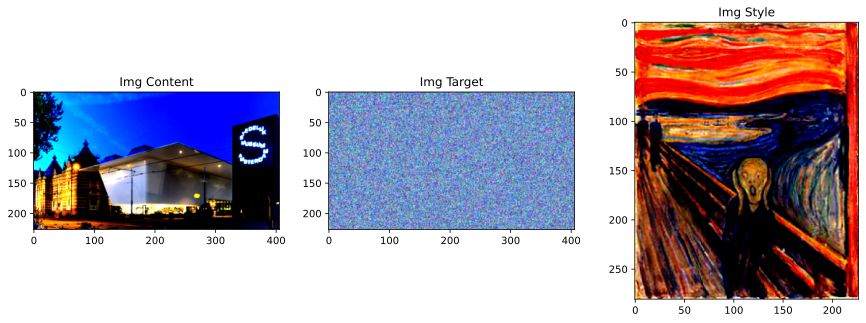

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pic = img_content_T.cpu().numpy().squeeze().transpose((1, 2, 0))
pic =  (pic-np.min(pic)/(np.max(pic)-np.min(pic)))
ax[0].imshow(pic)
ax[0].set_title("Img Content")

pic = img_target_T.cpu().numpy().squeeze().transpose((1, 2, 0))
pic =  (pic-np.min(pic)/(np.max(pic)-np.min(pic)))
ax[1].imshow(pic, cmap="hot", vmax=.1)
ax[1].set_title("Img Target")

pic = img_style_T.cpu().numpy().squeeze().transpose((1, 2, 0))
pic =  (pic-np.min(pic)/(np.max(pic)-np.min(pic)))
ax[2].imshow(pic)
ax[2].set_title("Img Style")

plt.show()

In [101]:
def get_feature_maps(img: torch.tensor, net: nn.Module):
    feature_maps = []
    for i in range(len(net.features)):
        img = net.features[i](img)
        if "Conv2" in str(net.features[i]):
            feature_maps.append(img)
    return feature_maps

In [102]:
def gram_matrix(M):
    _,chans,height,width = M.shape
    M = M.reshape(chans,height*width)  
    # compute and return covariance matrix
    gram = torch.mm(M,M.t()) / (chans*height*width)
    return gram

Epoch 1: Content Loss -> 0.00 Style Loss -> 2510.35 Combined Loss -> 2510.35
Epoch 101: Content Loss -> 0.60 Style Loss -> 135.20 Combined Loss -> 135.80
Epoch 201: Content Loss -> 0.84 Style Loss -> 37.73 Combined Loss -> 38.57
Epoch 301: Content Loss -> 1.00 Style Loss -> 13.81 Combined Loss -> 14.81
Epoch 401: Content Loss -> 1.12 Style Loss -> 5.82 Combined Loss -> 6.93
Epoch 501: Content Loss -> 1.21 Style Loss -> 3.02 Combined Loss -> 4.23
Epoch 601: Content Loss -> 1.27 Style Loss -> 1.90 Combined Loss -> 3.17
Epoch 701: Content Loss -> 1.31 Style Loss -> 1.41 Combined Loss -> 2.71
Epoch 801: Content Loss -> 1.33 Style Loss -> 1.09 Combined Loss -> 2.42
Epoch 901: Content Loss -> 1.35 Style Loss -> 1.07 Combined Loss -> 2.42
Epoch 1001: Content Loss -> 1.35 Style Loss -> 0.86 Combined Loss -> 2.21
Epoch 1101: Content Loss -> 1.35 Style Loss -> 0.83 Combined Loss -> 2.18
Epoch 1201: Content Loss -> 1.35 Style Loss -> 0.79 Combined Loss -> 2.14
Epoch 1301: Content Loss -> 1.35 Sty

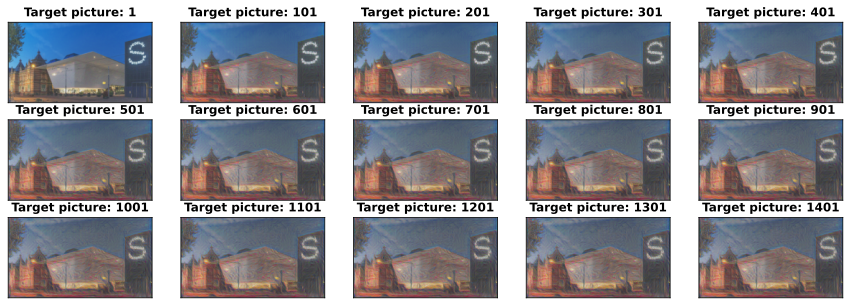

In [116]:
target = img_content_T.detach().clone()
target.requires_grad = True
target = target.to(device=device)
alexnet.to(device=device)
style_maps = get_feature_maps(img_style_T, alexnet)
content_maps = get_feature_maps(img_content_T, alexnet)


style_loss = 0
content_loss = 0
style_scaling = 1e7

epochs = 1500
optimizer = torch.optim.RMSprop([target], lr=.005)

fig, axs = plt.subplots(3, 5, figsize=(15, 5))
ax = axs.flatten()
axi=0
for ei in range(epochs):
    target_maps = get_feature_maps(target, alexnet)
    content_loss = 0
    style_loss = 0
    for i in range(len(target_maps)):
        if i in content_layer_idxs:
            content_loss += torch.mean((target_maps[i] - content_maps[i])**2)
        if i in style_layer_idxs:
            target_gm = gram_matrix(target_maps[i])
            style_gm = gram_matrix(style_maps[i])
            style_loss += torch.mean((target_gm - style_gm)**2)*style_weights[style_layer_idxs.index(i)]
    combined_loss = style_scaling*style_loss + content_loss

    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()

    if ei%100==0: 
        print(f"Epoch {ei+1}: Content Loss -> {content_loss.cpu().item():.2f} Style Loss -> {style_scaling*style_loss.cpu().item():.2f} Combined Loss -> {combined_loss.cpu().item():.2f}")
        pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
        
        ax[axi].imshow(pic)
        ax[axi].set_title(f'Target picture: {ei+1}',fontweight='bold')
        ax[axi].set_xticks([])
        ax[axi].set_yticks([])
        axi+=1
plt.show()

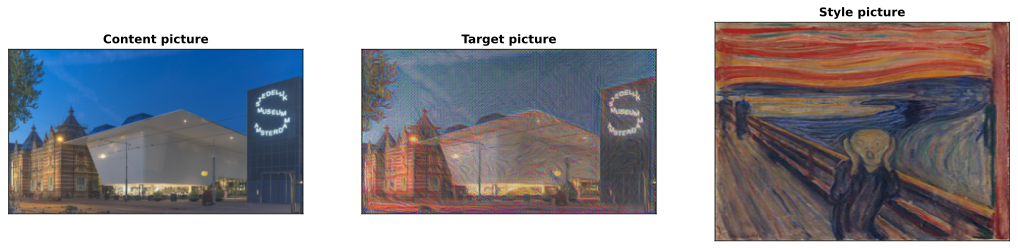

In [105]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img_content_T.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img_style_T.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()